# Chapter 7 Lab 4

## Goal
In this lab, we will continue to use the DoTalicious data set from previous labs. Using Logistic Regression for classification, we will attempt to predict a player's SkillLevel. If you remember, the raw data represents skill level with numbers between 0 and 3 with 0 being Novice and 3 being Expert. We would expect a player's SkillLevel to be a reflection of their other stats such as Kills and Deaths.

Scikit-learn has a LogisticRegression package that we will use. We will also use GridSearchCV to try different iterations of the LogisticRegression solver (more on this below) to find the optimal number of iterations. We will not use RepeatKFold again for this exersice.

## Preparation

Load the required packages below.

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, classification_report, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from io import StringIO

import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [70]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.drop(['PlayerID'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [71]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory u

In [72]:
dota_df1 = dota_df1.rename(columns=lambda x: x.strip())
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GamesPlayed      868 non-null    int64  
 1   GamesWon         868 non-null    int64  
 2   GamesLeft        868 non-null    int64  
 3   Ditches          868 non-null    int64  
 4   Points           868 non-null    float64
 5   SkillLevel       868 non-null    object 
 6   Kills            868 non-null    int64  
 7   KillsPerMin      868 non-null    float64
 8   Deaths           868 non-null    int64  
 9   Assists          868 non-null    int64  
 10  CreepsKilled     868 non-null    int64  
 11  CreepsDenied     868 non-null    int64  
 12  NeutralsKilled   868 non-null    int64  
 13  TowersDestroyed  868 non-null    int64  
 14  RaxsDestroyed    868 non-null    int64  
 15  TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory usage: 108.6+ KB


Notice that we will need to change some data types.

In [73]:
dota_df1['TotalTime'] = pd.to_numeric(dota_df1['TotalTime'], errors='coerce')

We'll make a quick fix to an odd value in SkillLevel too. Here, we'll remove the row.

In [74]:
dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

Lastly, let's work on the SkillLevel column! We need to change it to categorical.

In [75]:
dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GamesPlayed      868 non-null    int64   
 1   GamesWon         868 non-null    int64   
 2   GamesLeft        868 non-null    int64   
 3   Ditches          868 non-null    int64   
 4   Points           868 non-null    float64 
 5   SkillLevel       868 non-null    category
 6   Kills            868 non-null    int64   
 7   KillsPerMin      868 non-null    float64 
 8   Deaths           868 non-null    int64   
 9   Assists          868 non-null    int64   
 10  CreepsKilled     868 non-null    int64   
 11  CreepsDenied     868 non-null    int64   
 12  NeutralsKilled   868 non-null    int64   
 13  TowersDestroyed  868 non-null    int64   
 14  RaxsDestroyed    868 non-null    int64   
 15  TotalTime        867 non-null    float64 
dtypes: category(1), float64(3), int64(12)
memory

Next, let's check for null values and remove those.

In [76]:
dota_df1.isna().sum().sum()

1

In [77]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
517,0,0,0,0,1000.0,0,0,0.0,0,0,0,0,0,0,0,NaN


In [78]:
dota_df1.drop([517], inplace=True)

In [79]:
dota_df1.isna().sum().sum()

0

## Step 2: Set up training and testing set and preprocess

The first step is to split the data into two pieces of two parts each: first into X, y for predictors and target respectively and then train (X,y) and test (X,y).

As discussed in Lab 2, we will also standardize the data after splitting it.

Keep in mind, as also mentioned in Lab 2, there is a mild debate about whether or not you should also scale the y (target) data because in doing so, you lose interpretability but in not doing so you do NOT usually lose any model quality.

Here, we will only standardize the independent variables (aka predictors or X).

In [80]:
y = dota_df1['SkillLevel']
X = dota_df1.drop(['SkillLevel'], axis=1, inplace=False)

We set 'test_size' to 0.25, which means the training data size will be 75% of the original data sets X and y.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [82]:
scaler = StandardScaler()
Xtrn_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
Xtst_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

## Step 3: Apply the Logistic Regression Model

The sklearn LogisticRegression package defaults to a binary approach. Clearly, with more than 2 classifications, this would not work. It is important to set 'multi_class' to 'multinomial'.

Also, this limits the types of allowable solvers as well. Here, we'll pick the default 'lbfgs' which is one of the solvers that work well with multinomial problems. Given that, we also set 'penalty' to None. We will discuss these options in Chapter 8 when we talk about things such as Lasso and Ridge Regression.

Lastly, it is best practice to run and evaluate these types of models using cross validation. We already have used it here and in earlier labs to mimic the R output. There will be an more in-depth discussion of cross validation in Chapter 8 as well.


In [83]:
#define model
logreg = LogisticRegression(solver= 'lbfgs', multi_class='multinomial', penalty=None)

opt_iters = list(range(10, 210, 10))
params = {'max_iter': opt_iters}

#create model, perform Repeated CV and evaluate model
scores = GridSearchCV(logreg, params, scoring='neg_log_loss', n_jobs=-1, verbose=1)
scores.fit(Xtrn_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=LogisticRegression(multi_class='multinomial',
                                          penalty=None),
             n_jobs=-1,
             param_grid={'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                      110, 120, 130, 140, 150, 160, 170, 180,
                                      190, 200]},
             scoring='neg_log_loss', verbose=1)

In [84]:
scores.best_estimator_

LogisticRegression(max_iter=10, multi_class='multinomial', penalty=None)

The most common way to evaluate classification visually is with a confusion matrix. Bascially, if you predict skill level 0 and the original 'true' label was 0, then you have a true positive. Depending on your intent, this might be what you're hoping to maximize.

You will explore the types of metrics in Chapter 8 in more detail.

Below is a confusion matrix.

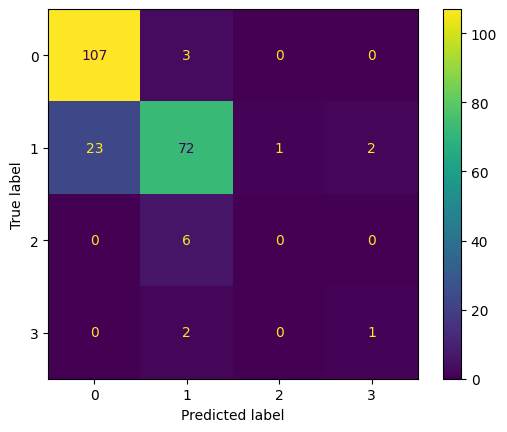

In [85]:
final_model = scores.best_estimator_
log_pred = final_model.predict(Xtst_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, log_pred)
plt.show()

In R, the output is much more detailed. Python produces a report that is more focused on the three metrics you will use most often. Again, you will see these in more detail in the next chapter.

'Support' is simply the total number of observations for each particular class. So, for the first line, 'class 0' there are 110 observations.

In [86]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, log_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.82      0.97      0.89       110
     class 1       0.87      0.73      0.80        98
     class 2       0.00      0.00      0.00         6
     class 3       0.33      0.33      0.33         3

    accuracy                           0.83       217
   macro avg       0.51      0.51      0.51       217
weighted avg       0.81      0.83      0.82       217



We can also call up the Kappa separately if we're worried about an imbalance.

In [91]:
cohen_kappa_score(y_test, log_pred)

0.6741477272727272

Lastly, R focuses on 'specificity' and 'sensitivity'. These are actually two forms of 'recall'. Recall of a positive class is sensitivity while recall of a negative class is specificity.

The issue is that this works in binary classification only. For present purposes, we can manipulate the predicted data into a binary for each class we have and then call up specificity and sensitivity.

In [88]:
prfs = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test).astype(float)==l, np.array(log_pred.astype(float))==l, pos_label=True,average=None)
    prfs.append([recall[1],recall[0]])

pd.DataFrame(prfs, columns = ['sensitivity','specificity']).transpose()

,0,1,2,3
sensitivity,0.972727,0.734694,0.000000,0.333333
specificity,0.785047,0.907563,0.995261,0.990654


Lastly, when we say our metrics are 'good', what do we mean? Usually, we're comparing to some standard. If our accuracy is 80% but throwing darts at a dartboard that is divided into sections representing our classes gets us 85% accuracy, our model isn't all that meaningful!

In this case, we create a baseline model - in Python it's called 'DummyClassifier'. In R, it is 'nullmodel'.

In [89]:
dummy_mod = DummyClassifier(strategy='most_frequent')
dummy_mod.fit(X_train, y_train)


DummyClassifier(strategy='most_frequent')

In [90]:
dummy_mod.score(X_train, y_train)

0.5169230769230769

So our dummy model gets us a score of 50% accuracy. The efforts we took with our model took us to 83%. It is safe to say that the model is an improvement over the base case!